In [ ]:
#!jupyter nbconvert --to=python DIN_WOA_Comparison_python3.ipynb

# After changes in the script using Jupyter notebook, save the notebook, run this line, and clear the output.

In [1]:
class DINcomp:
    '''
    class DINcomp(runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 WOAvar='n_an',mapproj='pc',savefig=False,layerwise=False)
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 WOAvar='n_an',
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.ncpath = ncpath
        self.fyear = first_year
        self.lyear = last_year
        self.WOAvar = WOAvar
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array

        import matplotlib.pyplot as plt
        import numpy as np
        #from netCDF4 import Dataset
        #from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf

        from load_interp_WOA_python3 import WOAdata
        from plot_Taylor_normalized import plt_Taylor_norm

        # load FESOM data -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(self.meshpath)
        years = [self.fyear, self.lyear]

        # check variables
        #NCfesom = self.resultpath + '/DIN.'+self.runname+'.'+str(self.fyear)+'.nc'
        #!ncdump -h $NCfesom

        labelfesom = 'FESOM DIN {0}-{1}'.format(self.fyear,self.lyear)
        unitfesom = 'DIN [mmol m$^{-3}$]' # equals to mumol/L

        # load data -------------------------------------------------------------------------------------
        DINfesom = pf.get_data(resultpath, "DIN", years, mesh, 
                               how="mean", compute=True, runid=self.runname, silent=True)


        # load WOA data  -------------------------------------------------------------------------------------
        din_int = WOAdata(self.runname,self.resultpath,self.meshpath,self.ncpath,self.WOAvar, get_overview=False).woa_int    
        #print(np.shape(din_int))
        
        labelwoa = 'World Ocean Atlas DIN'
        unitwoa = 'DIN [$\mu$mol L$^{-1}$]'

        # apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
        # assumption: there is no ocean where value in FESOM == 0
        din_int_ma = np.copy(din_int)
        din_int_ma[DINfesom == 0] = 0

        # plot WOA and FESOM ----------------------------------------------------------------------------------
        if(self.layerwise):
            if(self.depth_array == []):
                depth_array = (0,50,200,1000,2000,4000)

            for d in depth_array:
                # get mesh index closest to desired depth
                i = pf.ind_for_depth(d,mesh) 
                # get midlevel depth
                plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

                if(True):
                    print('\nInput depth = {0}, plotting at depth = {1} m\nFESOM min = {2}, max = {3}\nWOA min = {4}, max = {5}'.format(
                        d,plot_depth,
                        np.nanmin(DINfesom[:,i]),np.nanmax(DINfesom[:,i]),
                        np.nanmin(din_int_ma[:,i]),np.nanmax(din_int_ma[:,i])))

                pf.plot(mesh, [din_int_ma[:,i],DINfesom[:,i], din_int_ma[:,i]-DINfesom[:,i]], 
                        rowscol= (1,3),
                        levels = (0,45,40),
                        units=unitwoa + '\n at depth = {0} m'.format(plot_depth), 
                        mapproj=self.mapproj, # robinson projection takes more time!
                        titles=[labelwoa, labelfesom, 'WOA - FESOM'],figsize = (20,20)
                       )

            # statistics  -------------------------------------------------------------------------------------
            # preparation of datasets
            if np.isnan(np.min(din_int)): print('WARNING: The interpolated WOA field contains NaNs at depth')
            if np.isnan(np.min(DINfesom)): print('WARNING: The interpolated FESOM field contains NaNs at depth')


            for d in depth_array:
                # get mesh index closest to desired depth
                i = pf.ind_for_depth(d,mesh) 
                # get midlevel depth
                plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

                title = 'Taylor Diagram for DIN at {0} m'.format(plot_depth)
                plt_Taylor_norm(din_int[i,:],DINfesom[i,:],mask=True,title=title)

                if False:
                    # get statistics only from ocean gridpoints (same mask assumption as above)
                    ind_stat = np.where(DINfesom[i,:] != 0)

                    taylor_stats1 = sm.taylor_statistics(din_int[i,ind_stat],DINfesom[i,ind_stat])
                    sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
                    crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
                    ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])

                    label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

                    fig = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
                    sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                                          titleOBS = 'observation', markerLabel = label,
                                          markerLabelColor = 'c',
                                          markerColor = 'c', markerLegend = 'on',
                                          tickRMS = range(0,5,1), tickRMSangle = 135.0,
                                          colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                                          titleRMS = 'off', tickSTD = range(0,10,2 ),
                                          axismax = 10.0, 
                                          colSTD = 'b', styleSTD = '-.',
                                          widthSTD = 1.0, titleSTD = 'on',
                                          colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                                          titleCOR = 'on')
                    plt.title('Taylor Diagram for DIN at {0} m'.format(plot_depth), loc='right')
        
            if(self.savefig==True): print('\n***\n***Too many figures to export...\n***')
        
        # mean over depth  -------------------------------------------------------------------------------------
        else:
            
            DINfesom_mean = np.mean(DINfesom, axis = 1)
            din_int_ma_mean = np.mean(din_int_ma, axis = 1)
            #print(np.shape(DINfesom_mean), np.shape(din_int_ma_mean))

            print('\nPlotting DIN as mean over depth\nFESOM min = {0}, max = {1}\nWOA min = {2}, max = {3}'.format(
                    np.nanmin(DINfesom_mean),np.nanmax(DINfesom_mean),
                    np.nanmin(din_int_ma_mean),np.nanmax(din_int_ma_mean)))
    
            fig_data = pf.plot(mesh, [din_int_ma_mean,DINfesom_mean, din_int_ma_mean-DINfesom_mean], 
                    rowscol= (3,1),
                    levels = (0,35,36),
                    units=unitwoa, 
                    mapproj=self.mapproj, # robinson projection takes more time!
                    titles=['World Ocean Atlas: Interpolated DIN for initialization', 
                            'FESOM Dissolved Inorganic Nitrogen ({0}-{1})'.format(first_year,last_year),
                            'Initialization fields minus FESOM'],
                    figsize = (20,20)
                   )
            # fig export  -------------------------------------------------------------------------------------
            if(self.savefig==True):
                plt.savefig(self.savepath+self.runname+'_'+'DIN_WOA'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False)  
                
            # statistics  -------------------------------------------------------------------------------------            
            # preparation of datasets
            if np.isnan(np.min(din_int_ma_mean)): print('WARNING: The interpolated WOA field contains NaNs at depth')
            if np.isnan(np.min(DINfesom_mean)): print('WARNING: The interpolated FESOM field contains NaNs at depth')

            title = 'Taylor Diagram for DIN \n(mean over depth)'
            plt_Taylor_norm(din_int_ma_mean,DINfesom_mean,mask=True,title=title)

            if False: #old
                # get statistics only from ocean gridpoints (same mask assumption as above)
                ind_stat = np.where(DINfesom_mean != 0)

                taylor_stats1 = sm.taylor_statistics(din_int_ma_mean[ind_stat],DINfesom_mean[ind_stat])
                sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
                crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
                ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])

                label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

                fig_stat = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
                sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                                      titleOBS = 'observation', markerLabel = label,
                                      markerLabelColor = 'c',
                                      markerColor = 'c', markerLegend = 'on',
                                      tickRMS = range(0,5,1), tickRMSangle = 135.0,
                                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                                      titleRMS = 'off', tickSTD = range(0,10,2 ),
                                      axismax = 10.0, 
                                      colSTD = 'b', styleSTD = '-.',
                                      widthSTD = 1.0, titleSTD = 'on',
                                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                                      titleCOR = 'on')
                plt.title('Taylor Diagram for DIN \n(mean over depth)', loc='right')  
                
            # fig export  -------------------------------------------------------------------------------------
            if(self.savefig==True):                
                plt.savefig(self.savepath+self.runname+'_'+'DIN_WOA_Taylor'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False)  
        


Depth is None, 3d field will be returned
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DIN as mean over depth
FESOM min = 0.005410965532064438, max = 34.37604522705078
WOA min = 0.0005629408827170412, max = 34.985260415584484


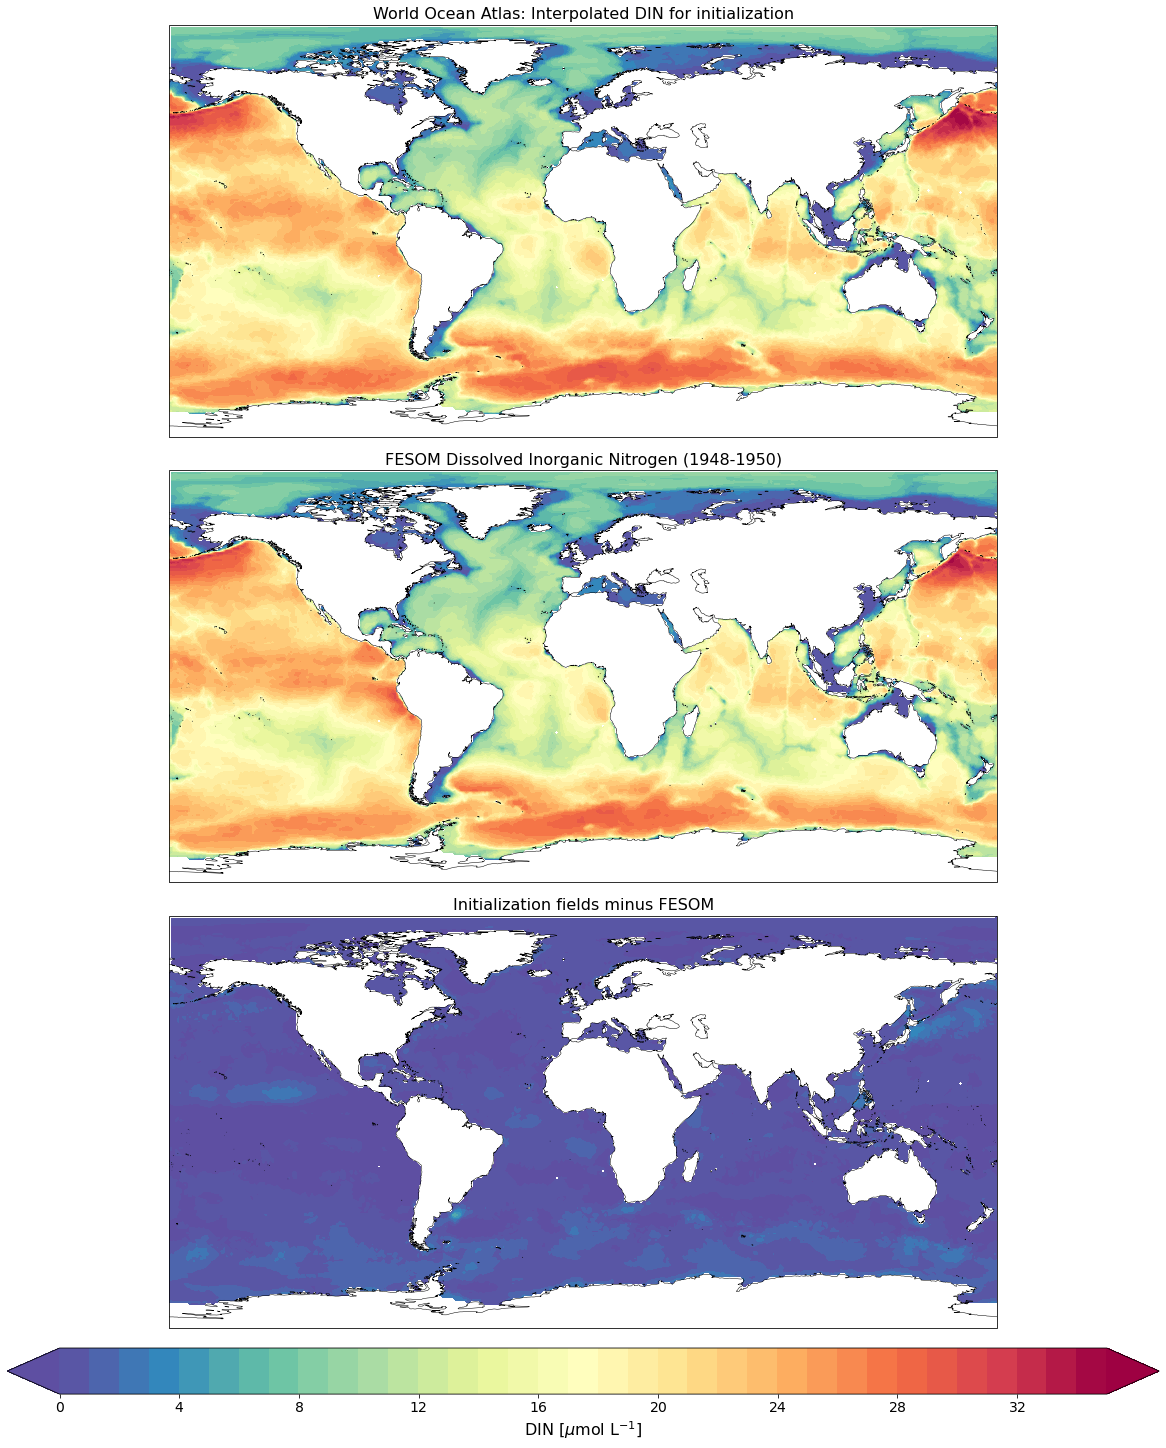

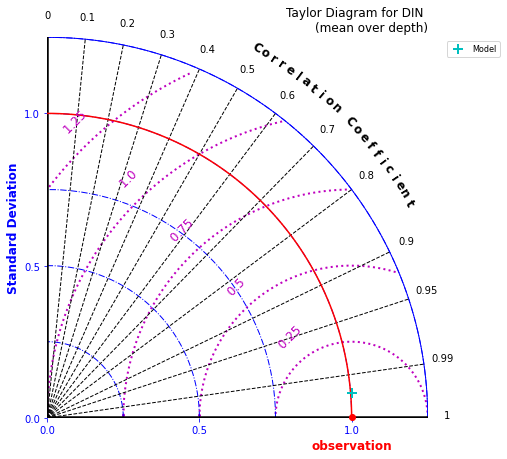

In [3]:
### TESTING ###
if __name__ == "__main__":
    
    # run specification -------------------------------------------------------------------------------------
    runid      =  'mo1'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    htmlname     =  runid + '.html'
    htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    #modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
    #modulepath   = '/home/ollie/jhauck/py_fesom/modules/'

    #obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # period of analysis ------------------------------------------------------------------------------------

    first_year = 1948
    last_year  = 1950

    # WOA ------------------------------------------------------------------------------------    
    ncpath                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
    #!ncdump -h $ncpath
    
    # now test:
    test = DINcomp(runid,resultpath,savepath,meshpath,ncpath,first_year,last_year,layerwise=False,savefig=False)